In [8]:
import numpy as np
import sympy as sp
from IPython.display import display
from itertools import permutations
from copy import deepcopy
import matplotlib.pyplot as plt

from MSA_class import MultipleSequenceAlignment
from Qiskit_class import QiskitSimulation

In [9]:
my_strings   = np.array(["AG","G"])
my_penalties = np.array([1,1,1])*2
my_msa       = MultipleSequenceAlignment(strings = my_strings, penalties = my_penalties) 

solutions = [my_msa.initial_bitstring,np.array([1,0,0,1,0,1],dtype=np.float64)]


print("Initial matrix:\n",my_msa.initial_MSA)

print("Valid solutions:")
for solution in solutions:
    print(my_msa.bit_state_2_matrix(solution))


Q, h, d   = my_msa.QUBO_model
J, g, c   = my_msa.Ising_model

normalize_weights = False

if normalize_weights:
    J *= 1./np.max(np.array([np.max(J),np.max(g)]))
    g *= 1./np.max(np.array([np.max(J),np.max(g)]))
    Q *= 1./np.max(np.array([np.max(Q),np.max(h)]))
    h *= 1./np.max(np.array([np.max(Q),np.max(h)]))
Q

Initial matrix:
 [['A' 'G']
 ['G' '_']]
Valid solutions:
[['A' 'G']
 ['G' '_']]
[['A' 'G']
 ['_' 'G']]


array([[ 2.,  4.,  2.,  0.,  2.,  0.],
       [ 0.,  2.,  2.,  2.,  0.,  2.],
       [ 0.,  0.,  2.,  4., -1.,  0.],
       [ 0.,  0.,  0.,  2.,  0., -1.],
       [ 0.,  0.,  0.,  0.,  2.,  4.],
       [ 0.,  0.,  0.,  0.,  0.,  2.]])

In [10]:
## Creating all permutations
state_dim = len(my_msa.initial_bitstring)
all_permutations = []
for i in range(state_dim + 1):
    current_perm = np.zeros(state_dim,dtype=int)
    for ones in range(i):
        current_perm[ones] = 1
    letter_perms = list(set(permutations(list(current_perm))))
    for perm in letter_perms:
        all_permutations.append(np.array(list(perm),dtype=int).reshape((len(perm),1)))
print("Number of permutations:",len(all_permutations))


Number of permutations: 64


In [11]:
## Finding best state according to QUBO model
best_state = None
best_cost = np.inf
history = []
for perm in all_permutations:
    cost = ((perm.T @ (Q @ perm) + h.T @ perm + d))[0][0]
    history.append([perm.T[0],cost])
    if cost < best_cost:
        best_cost = cost
        best_state = perm.T[0]
states = np.array(history,dtype=object)[:,0]
costs  = np.array(np.array(history,dtype=object)[:,1],dtype=float)
print("-- Best state and corresponding cost according to QUBO model:")
best_state,best_cost

-- Best state and corresponding cost according to QUBO model:


(array([1, 0, 0, 1, 0, 1]), -1.0)

In [12]:
## Finding best state according to Ising model
all_ising_permutations = np.array([1 - 2 * perm for perm in all_permutations])
best_ising_state = None
best_ising_cost = np.inf
ising_history = []
for perm in all_ising_permutations:
    cost = ((perm.T @ (J @ perm) + g.T @ perm + c))[0][0]
    ising_history.append([perm.T[0],cost])
    if cost < best_ising_cost:
        best_ising_cost = cost
        best_ising_state = perm.T[0]
ising_states = np.array(ising_history,dtype=object)[:,0]
ising_costs  = np.array(np.array(ising_history,dtype=object)[:,1],dtype=float)
print("-- Best state and corresponding cost according to Ising model:")
best_ising_state,best_ising_cost

-- Best state and corresponding cost according to Ising model:


(array([-1,  1,  1, -1,  1, -1]), -1.0)

In [13]:
## Checking that the two models evaluate to same cost on all perms
QUBO_costs = []
Ising_costs = []
for perm in all_permutations:
    x = perm.reshape((len(perm),1))
    s = (1-2*x)
    QUBO_costs.append((x.T @ Q @ x + h.T @ x + d)[0][0])
    Ising_costs.append((s.T @ J @ s + g.T @ s + c)[0][0])

print("Ising costs == QUBO costs:",np.all(np.array(QUBO_costs) == np.array(Ising_costs)))

Ising costs == QUBO costs: True


 QUBO costs sum: 320.0
Ising costs sum: 320.0


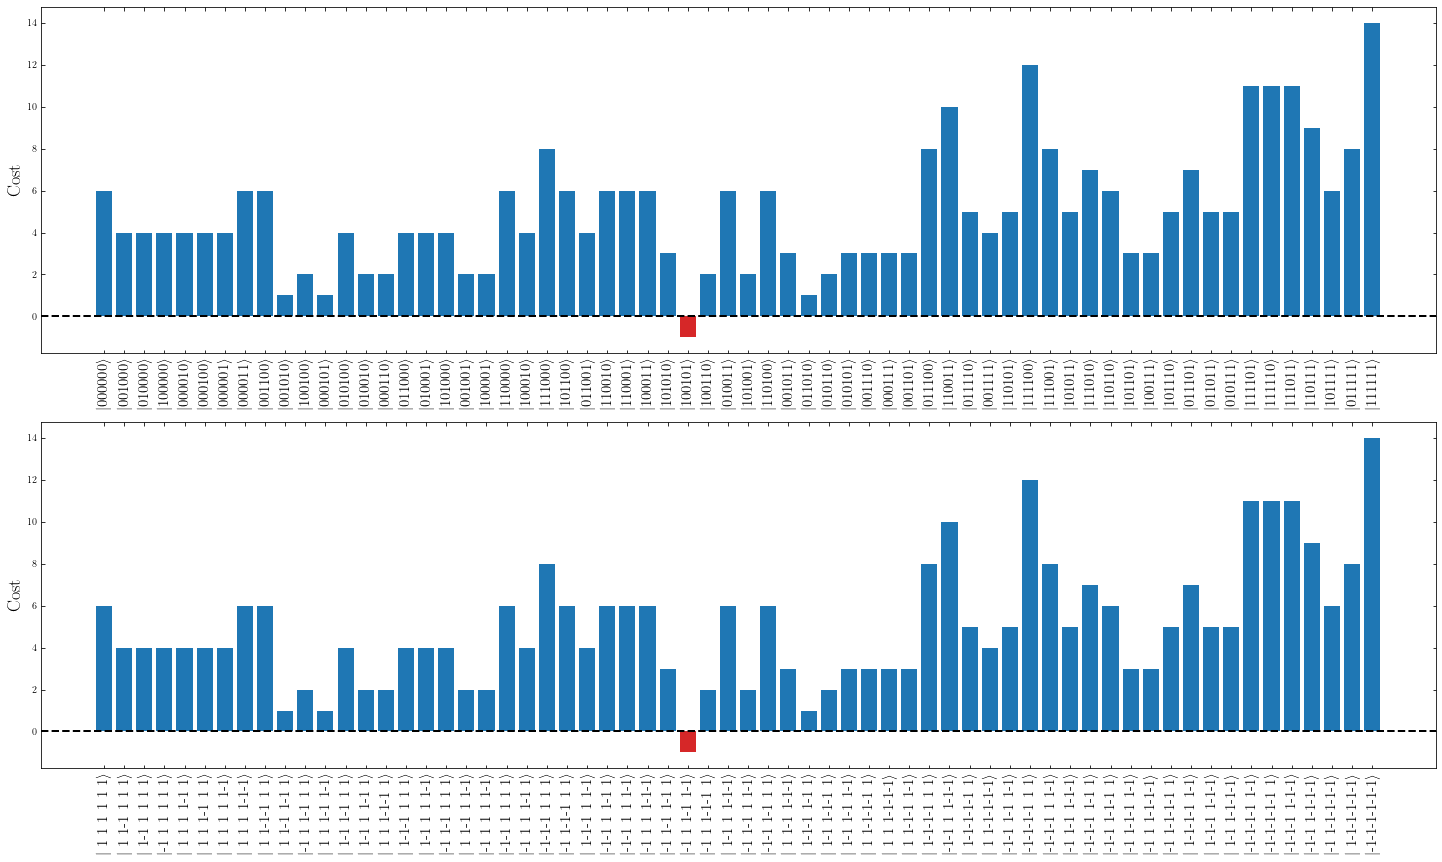

In [14]:
#################################################################################
history = []
for perm in all_permutations:
    cost = ((perm.T @ (Q @ perm) + h.T @ perm + d))[0][0]
    history.append([perm.T[0],cost])
states = np.array(history,dtype=object)[:,0]
costs  = np.array(np.array(history,dtype=object)[:,1],dtype=float)
print(" QUBO costs sum:",np.sum(costs))

xs = np.arange(0,len(states))
ys = costs

x_labels = []
for state in states:
    current_state_str = r"$|$"
    for nr in state.astype(np.int64):
        current_state_str += str(nr)
    current_state_str += r"$\rangle$"
    x_labels.append(current_state_str)

#################################################################################
ising_history = []
for perm in all_ising_permutations:
    cost = ((perm.T @ (J @ perm) + g.T @ perm + c))[0][0]
    ising_history.append([perm.T[0],cost])
ising_states = np.array(ising_history,dtype=object)[:,0]
ising_costs  = np.array(np.array(ising_history,dtype=object)[:,1],dtype=float)
print("Ising costs sum:",np.sum(ising_costs))

ising_xs = np.arange(0,len(ising_states))
ising_ys = ising_costs

ising_x_labels = []
for state in ising_states:
    current_state_str = r"$|$"
    for nr in state.astype(np.int64):
        if nr == -1:
            current_state_str += str(nr)
        else:
            current_state_str += " " + str(nr)
    current_state_str += r"$\rangle$"
    ising_x_labels.append(current_state_str)
#################################################################################

fig, ax = plt.subplots(2,1,figsize=(25,14))


ax[0].set_xticks(xs)
ax[0].set_xticklabels(x_labels, rotation = 90,size=15)
ax[0].bar(xs,ys,color=["tab:red" if ys[i] == np.min(ys) else "tab:blue" for i in range(len(xs))])
ax[0].hlines(0,np.min(xs)-0.05*np.max(xs),1.05*np.max(xs),ls="--",lw=2,color="k")
ax[0].set_xlim(np.min(xs)-0.05*np.max(xs),1.05*np.max(xs))
ax[0].set_ylabel("Cost",size=18)



ax[1].set_xticks(ising_xs)
ax[1].set_xticklabels(ising_x_labels, rotation = 90,size=15)
ax[1].bar(ising_xs,ising_ys,color=["tab:red" if ising_ys[i] == np.min(ising_ys) else "tab:blue" for i in range(len(ising_xs))])
ax[1].hlines(0,np.min(ising_xs)-0.05*np.max(ising_xs),1.05*np.max(ising_xs),ls="--",lw=2,color="k")
ax[1].set_xlim(np.min(ising_xs)-0.05*np.max(ising_xs),1.05*np.max(ising_xs))
ax[1].set_ylabel("Cost",size=18)

plt.show()